In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
import shap
import pickle
import cloudpickle
import numpy as np
import scipy as sp
import pandas as pd
from comparers import ModelComparer, plot_decision_boundary
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order, calc_instance_order,\
                       plot_2d, plot_feature_importance_bar, plot_feature_importance_scatter,\
                       plot_feature_effects, plot_forces, merge_explanations, plot_decision,\
                       perform_hierarchical_clustering, plot_dendrogram, extract_clustering,\
                       get_class_occurences_in_clusters, plot_feature_influence_comparison,\
                       plot_class_importances, plot_feature_effects_comparison, ensure_shap_values_are_3d
from diro2c_wrapper import generate_diro2c_explanation, plot_diro2c_2d, plot_diro2c_tree
shap.initjs()
%matplotlib inline

# Setup Task

In [4]:
X_train1, y = make_classification(n_samples=300, n_features=3, n_redundant=0, n_informative=2,
                           n_clusters_per_class=1, class_sep=0.75, random_state=0)
X_train1 *= 100
feature_names = np.array(['x1', 'x2', 'x3'])

In [5]:
X = X_train1.copy()
X[:, 0] = X[:, 1]

In [6]:
pd.DataFrame(X, columns=feature_names).describe()

,x1,x2,x3
count,300.000000,300.000000,300.000000
mean,84.138769,84.138769,9.979408
std,77.917955,77.917955,117.978412
min,-181.190181,-181.190181,-374.445022
25%,35.786394,35.786394,-59.339309
50%,83.158128,83.158128,34.019343
75%,131.776480,131.776480,93.596696
max,307.157526,307.157526,258.940851


In [7]:
from sklearn.linear_model import LogisticRegression
lm = LogisticRegression()
lm.fit(X_train1, y)
lm.intercept_, lm.coef_

(array([1.11353567]), array([[ 0.00049831, -0.02215288,  0.0307764 ]]))

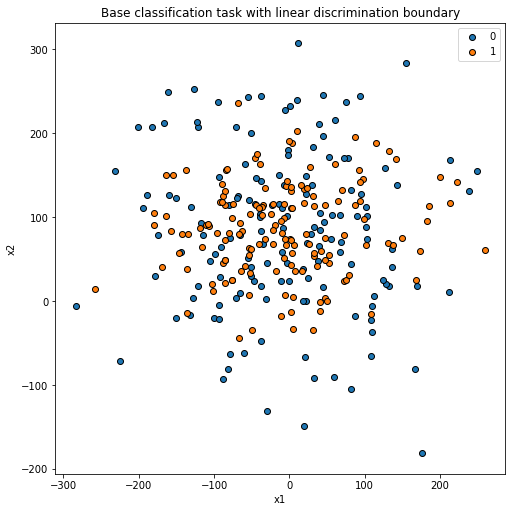

In [8]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)
plot_decision_boundary(X_train1, y, 'Base classification task with linear discrimination boundary',
                       feature_names, predict=lm.predict, class_names=lm.classes_, idx_x=0, idx_y=1,
                       fig=fig, ax=ax)

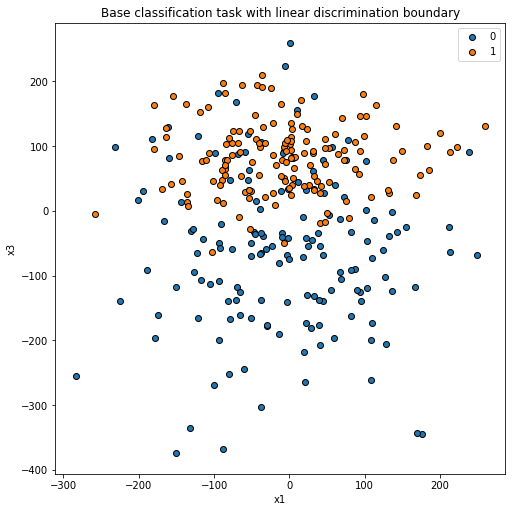

In [9]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)
plot_decision_boundary(X_train1, y, 'Base classification task with linear discrimination boundary',
                       feature_names, predict=lm.predict, class_names=lm.classes_, idx_x=0, idx_y=2,
                       fig=fig, ax=ax)

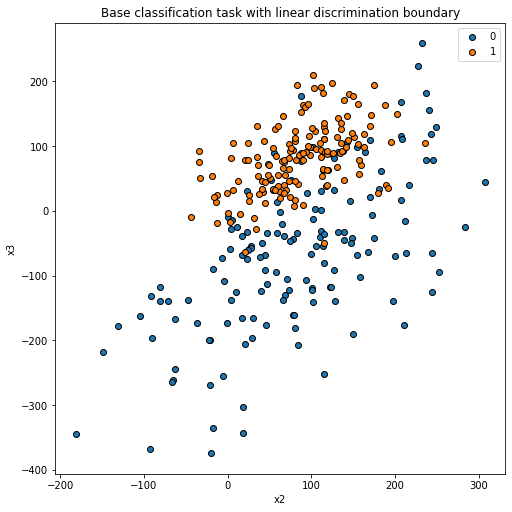

In [10]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)
plot_decision_boundary(X_train1, y, 'Base classification task with linear discrimination boundary',
                       feature_names, predict=lm.predict, class_names=lm.classes_, idx_x=1, idx_y=2,
                       fig=fig, ax=ax)

In [11]:
clf_a = lm

In [12]:
clf_b = LogisticRegression()
X_train2 = X_train1.copy()
X_train2[:, 0] = X_train1[:, 1]
X_train2[:, 1] = X_train1[:, 0]
clf_b.fit(X_train2, y)
clf_b.intercept_, lm.coef_

(array([1.11353567]), array([[ 0.00049831, -0.02215288,  0.0307764 ]]))

In [13]:
comparer = ModelComparer(clf_a, clf_b, feature_names)
comparer.fit(X, y)

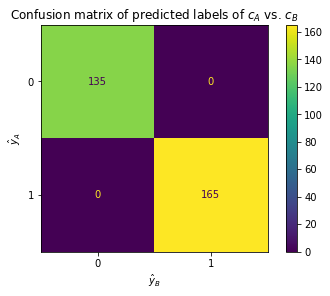

In [14]:
comparer.plot_confusion_matrix(X)

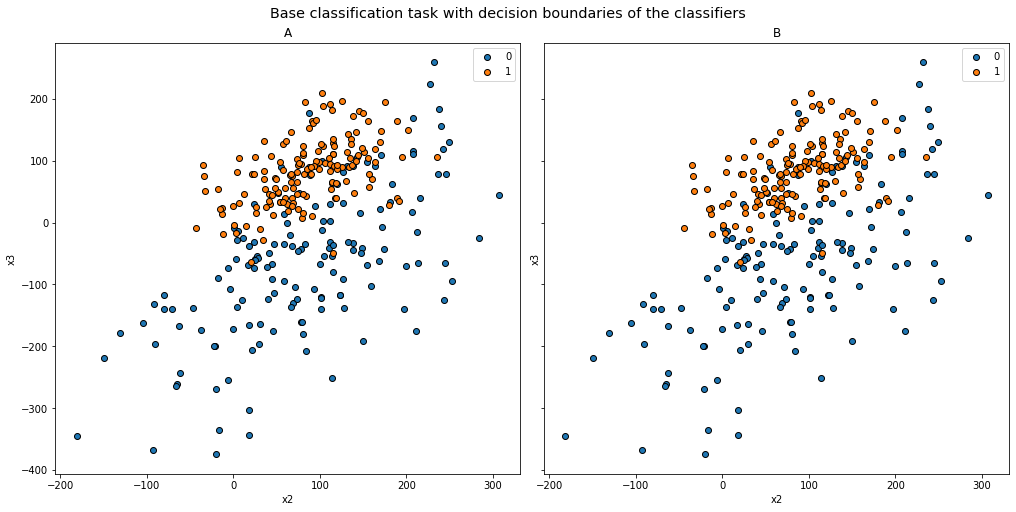

In [15]:
comparer.plot_individual_clf_decision_boundaries(X, y_true=y, kind='label', idx_x=1, idx_y=2)

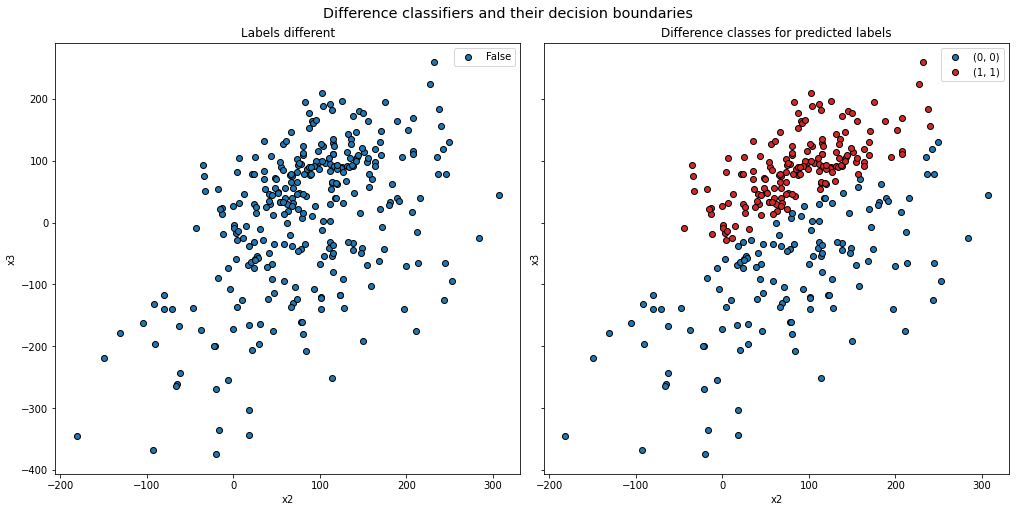

In [16]:
comparer.plot_decision_boundaries(X, idx_x=1, idx_y=2)

# Explain using Interpretability Methods

In [17]:
%%time
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])
explanations, indices_nonfinite_predictions, explanations_nonfinite = \
    generate_shap_explanations(comparer, X, masker=masker,
                               explanation_types=['indiv', 'indiv_diff', 'mclass_diff'],
                               space_types=['labels'])

CPU times: user 5.96 s, sys: 130 ms, total: 6.09 s
Wall time: 6.51 s


In [18]:
explanations.shape, indices_nonfinite_predictions.shape, explanations_nonfinite.shape

((300, 3), (0,), (0,))

In [19]:
is_pred_diff = comparer.predict_bin_diff(explanations.data)
mclass_diff = comparer.predict_mclass_diff(explanations.data)

# Global Explanations

## SHAP-based Individual Classifiers' Explanations

Both classifiers rely on two features. However, each disregards a different feature.

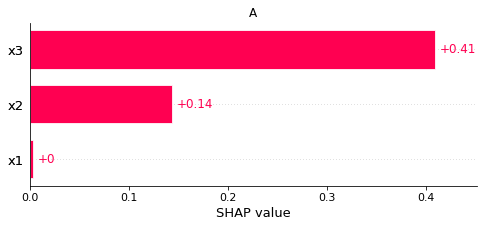

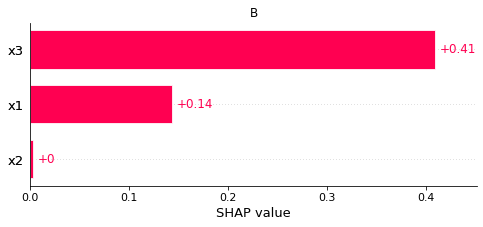

In [20]:
feature_order, feature_importance = calc_feature_order(explanations.indiv.labels.A[:, :, 1])
plot_feature_importance_bar(feature_importance, 'A', feature_order)
feature_order, feature_importance = calc_feature_order(explanations.indiv.labels.B[:, :, 1])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

In [21]:
feature_order, _ = calc_feature_order(explanations.indiv.labels[:, :, 1])

In [22]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(explanations.indiv.labels[:, [feature_idx], 1])
    plot_feature_effects(explanations.indiv.labels[:, [feature_idx], 1], color=is_pred_diff)
it = iter(feature_order)

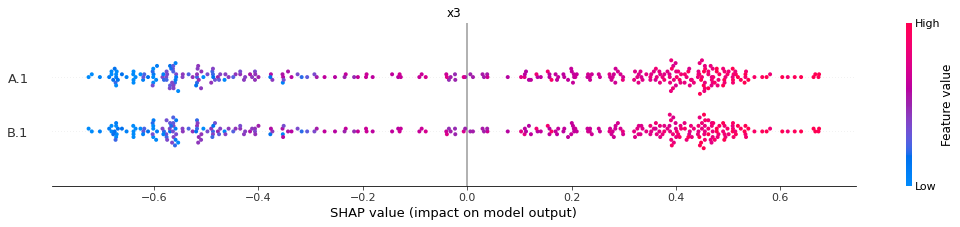

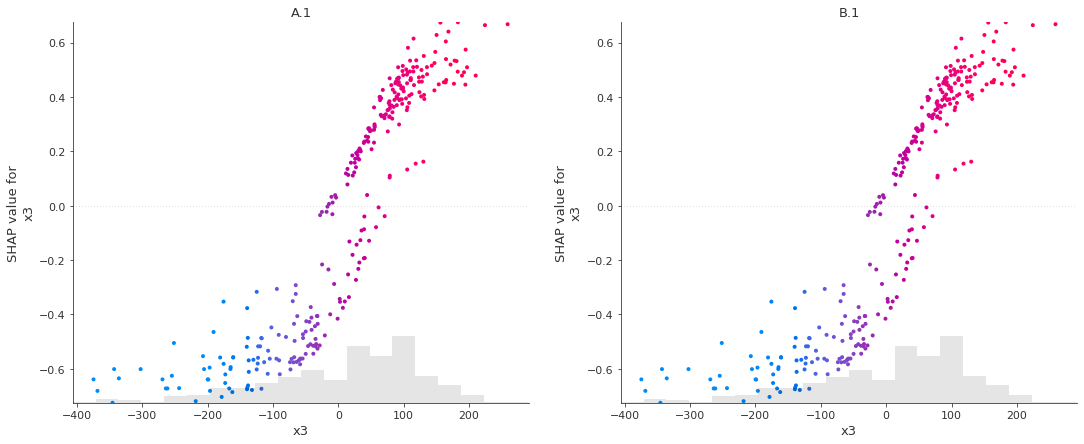

In [23]:
plot_next_feature()

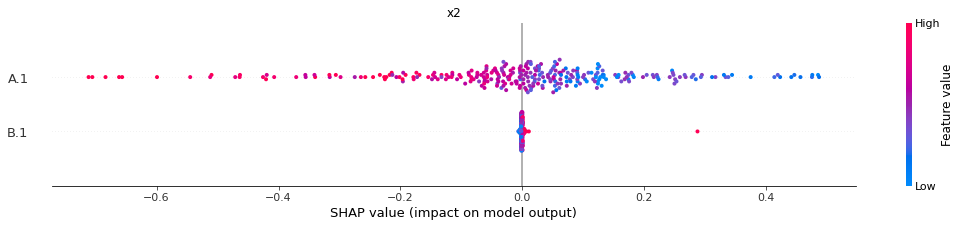

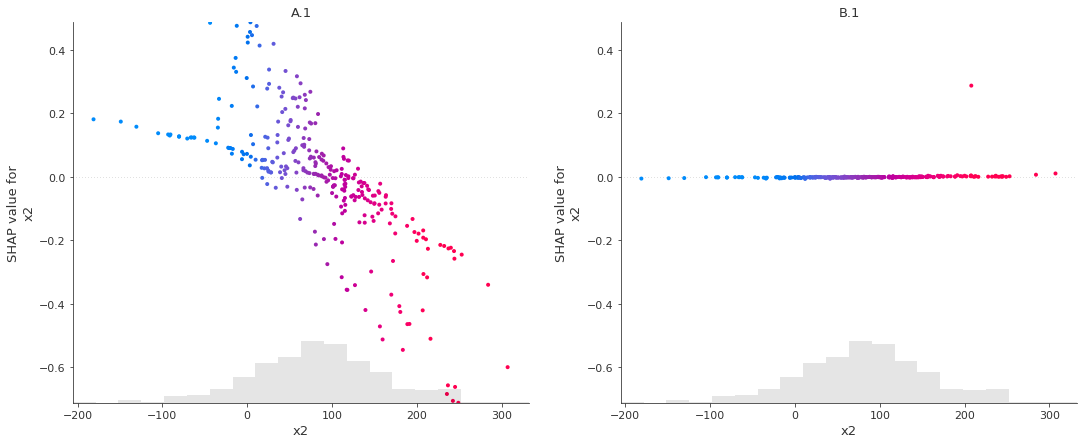

In [24]:
plot_next_feature()

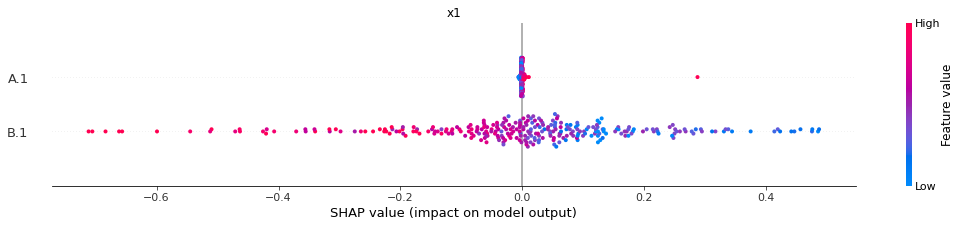

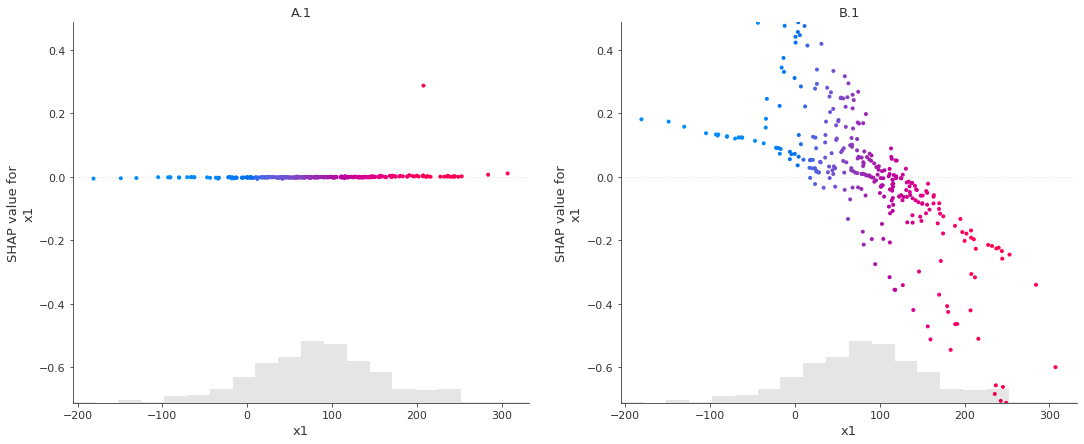

In [25]:
plot_next_feature()

## SHAP-based Difference Classifier Explanations

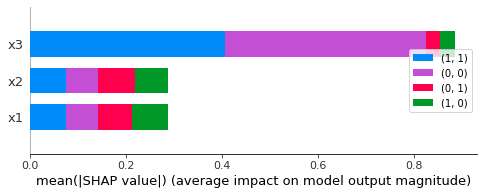

In [26]:
feature_order, feature_importances = calc_feature_order(explanations.mclass_diff.labels)
plot_feature_importance_bar(explanations.mclass_diff.labels)

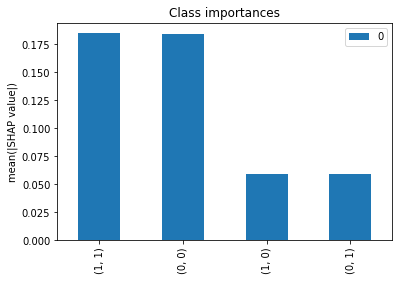

In [27]:
class_order, class_importances = calc_class_order(explanations.mclass_diff.labels)
plot_class_importances(class_importances, class_order, explanations.mclass_diff.output_names)

In [28]:
class_order = np.sort(class_order)

In [29]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(explanations.mclass_diff.labels[:, [feature_idx]][:, :, class_order])
    plot_feature_effects(explanations.mclass_diff.labels[:, [feature_idx]][:, :, class_order], color=is_pred_diff)
it = iter(feature_order)

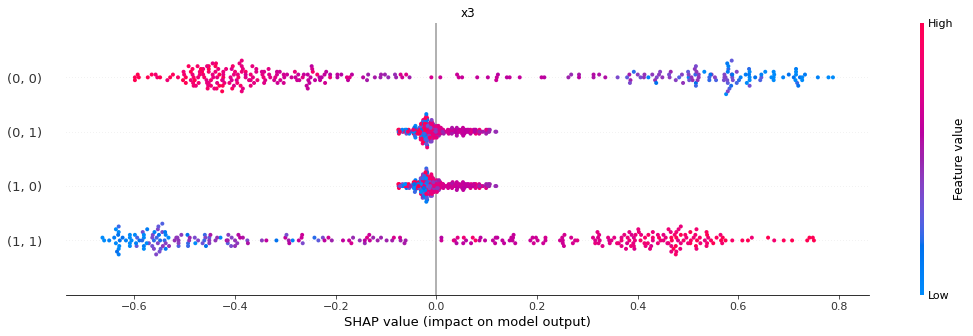

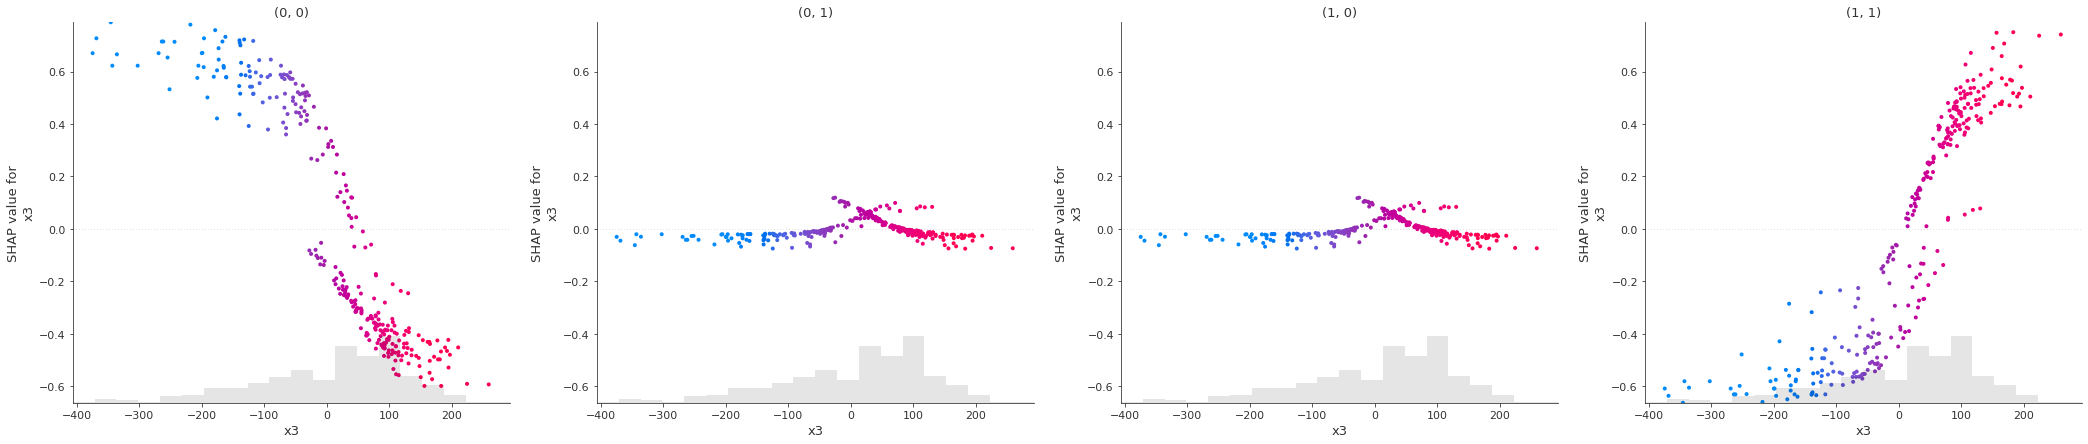

In [30]:
plot_next_feature()

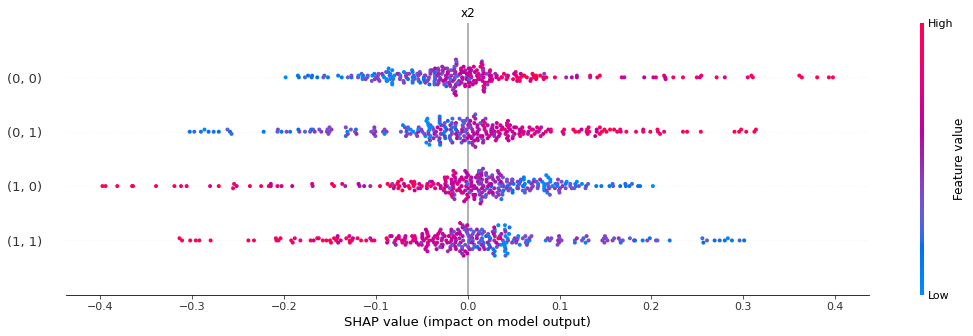

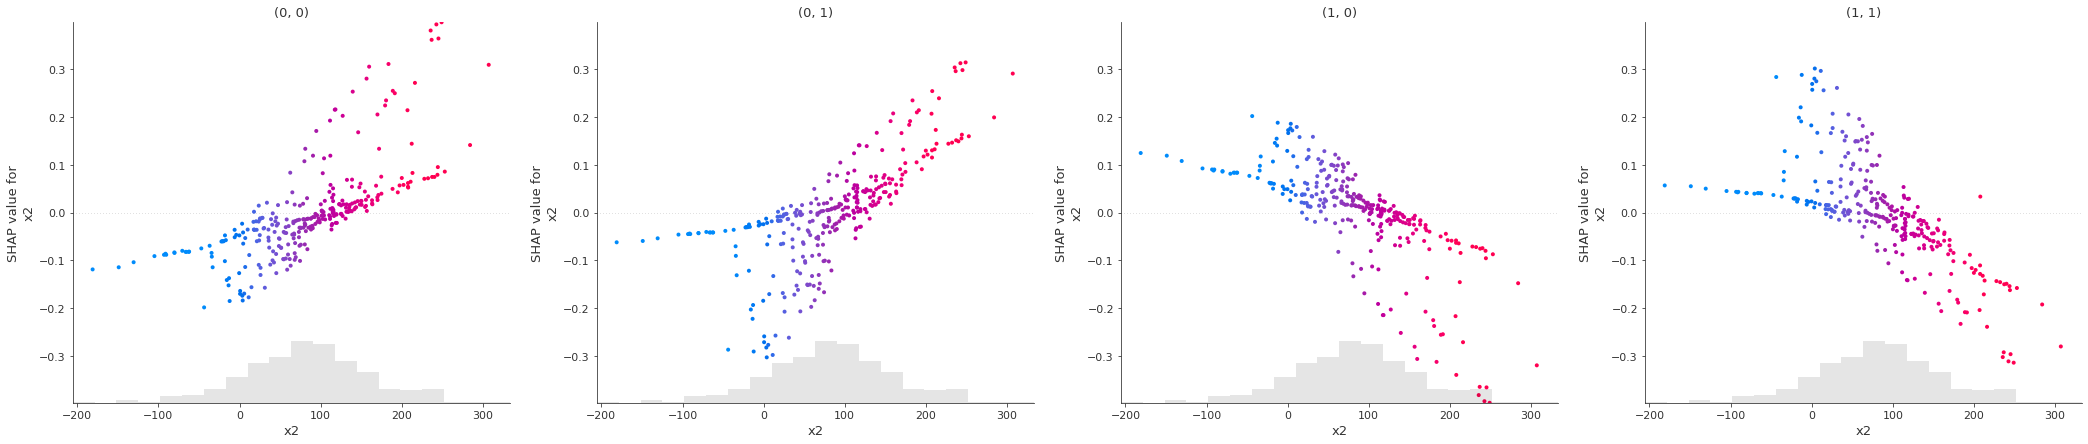

In [31]:
plot_next_feature()

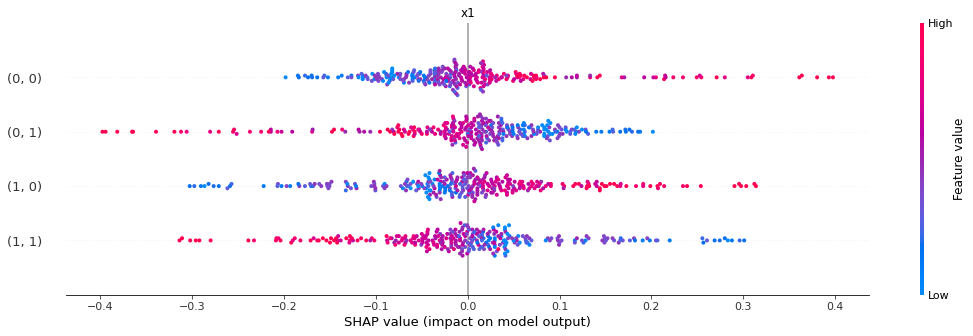

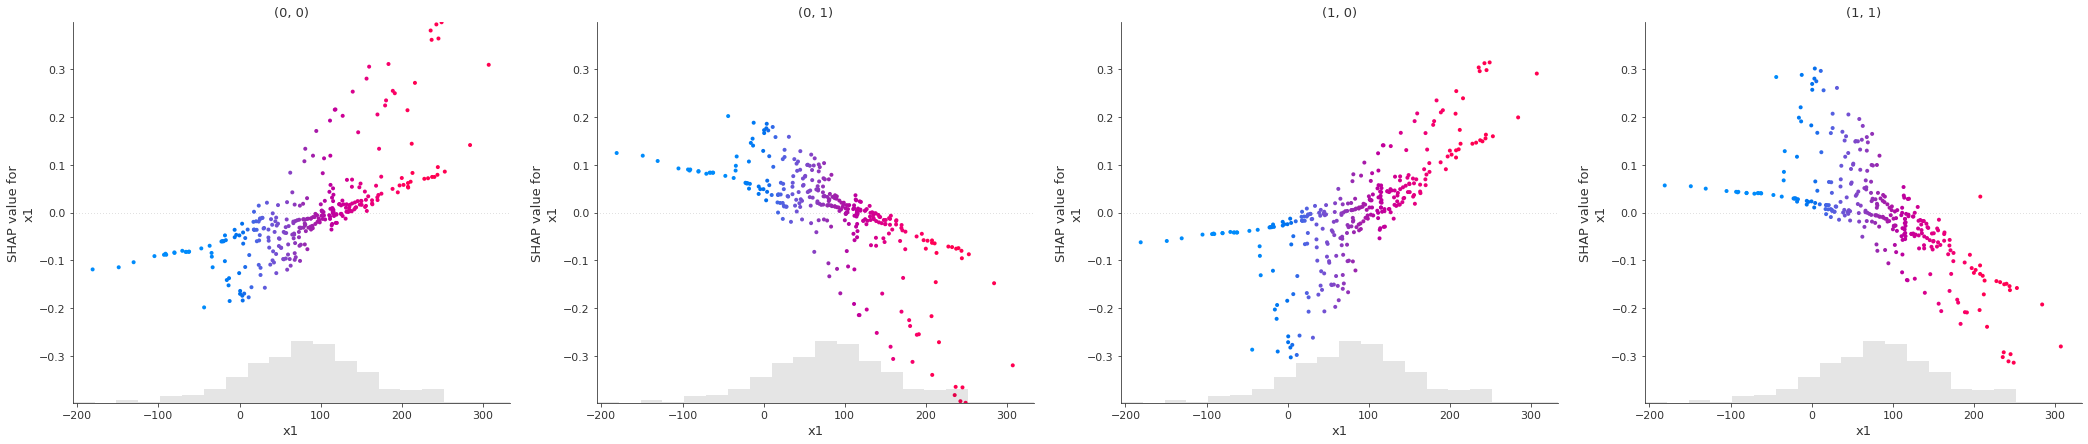

In [32]:
plot_next_feature()